In [8]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from skimage.morphology import opening, disk, closing
from pylab import *
from sklearn.cluster import KMeans
from PIL import Image
from __future__ import print_function
import cv2
import scipy
import glob
from skimage.io import imread, imshow
from skimage import img_as_ubyte

%matplotlib inline

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Image List**

In [10]:
flat_image = '/content/drive/MyDrive/airs-minisample/crop-saved/christchurch_196_40.tif'
gable_image = '/content/drive/MyDrive/airs-minisample/crop-saved/christchurch_36_31.tif'
hip_image = '/content/drive/MyDrive/airs-minisample/crop-saved/christchurch_36_33.tif'

images_list = [flat_image, gable_image, hip_image]

### **White Balancing**

1. **White patch algorithm**

In [11]:
#White balance image using White patch algorithm
def white_patch(image, percentile=100):
    white_patch_image = img_as_ubyte((image*1.0 / 
                                   np.percentile(image,percentile,
                                   axis=(0, 1))).clip(0, 1))
    return white_patch_image

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


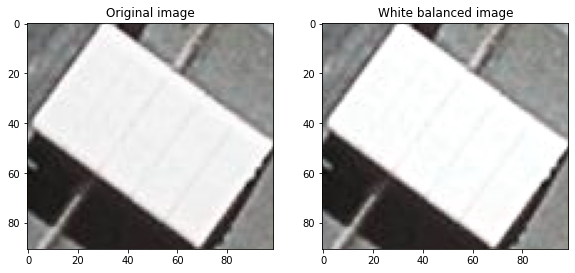

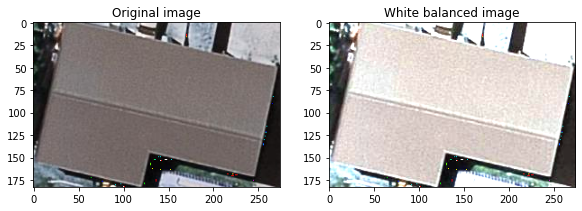

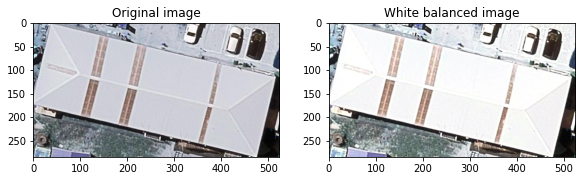

In [12]:
count = 1
for i in range(len(images_list)):
  image_np = cv2.imread(images_list[i], cv2.IMREAD_COLOR)
  image_white_patch = white_patch(image_np, 85)

  fig = plt.figure(figsize=(15,15))

  fig.add_subplot(1, 3, count)
  plt.subplot(1,3,1)
  plt.imshow(image_np)
  plt.title('Original image')

  fig.add_subplot(1, 3, count+1)
  plt.subplot(1,3,2)
  plt.imshow(image_white_patch)
  plt.title('White balanced image')

### **Active Contours**

In [13]:
# Bilate filtered image. Sharpened image helps to give a better edge approximation.

def active_contour_white_patch(image_white_patch):
  img = cv2.imread(image_white_patch)
  img = rgb2gray(img)

  s = np.linspace(0, 2*np.pi, 1000)
  x = 83 + 100*np.cos(s)
  y = 33 + 100*np.sin(s)
  init = np.array([x, y]).T

  '''
  alpha Higher values make snake contract faster
  beta Highervalue make snake smoother
  Gamma Timestepping parameter
  '''
  snake = active_contour(img, init, alpha=-1, beta=7, gamma=0.001, max_iterations=500)
  print(snake.shape)
  return snake

(1000, 2)
(1000, 2)


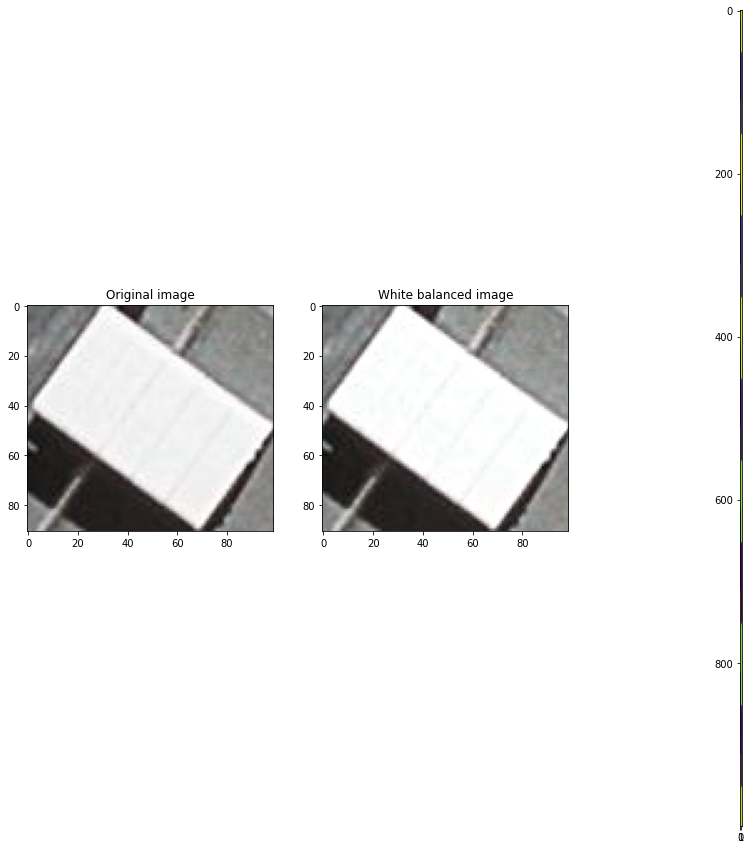

(1000, 2)
(1000, 2)


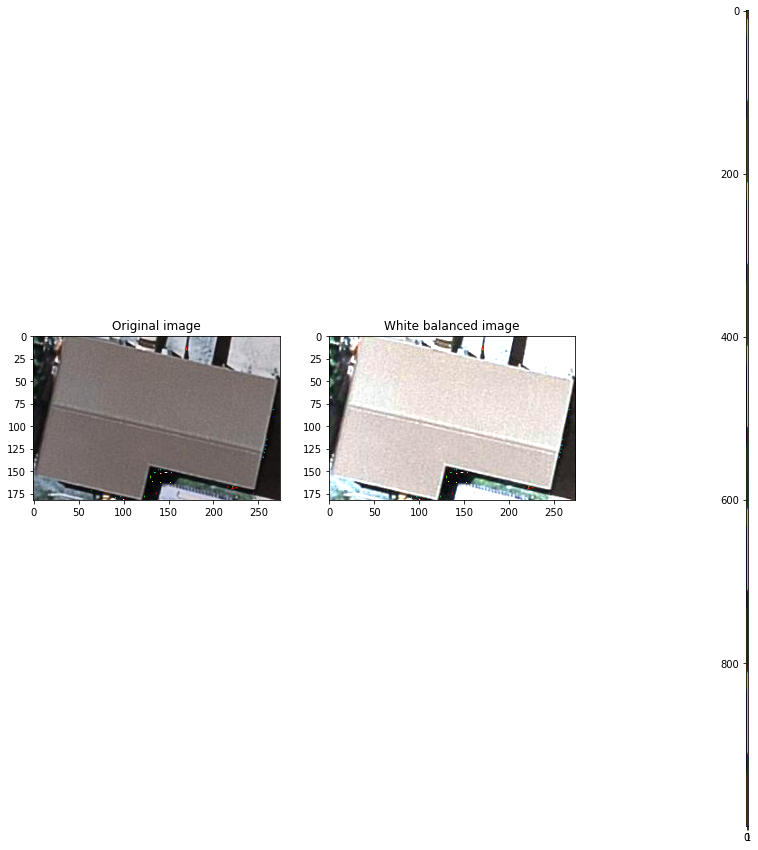

(1000, 2)
(1000, 2)


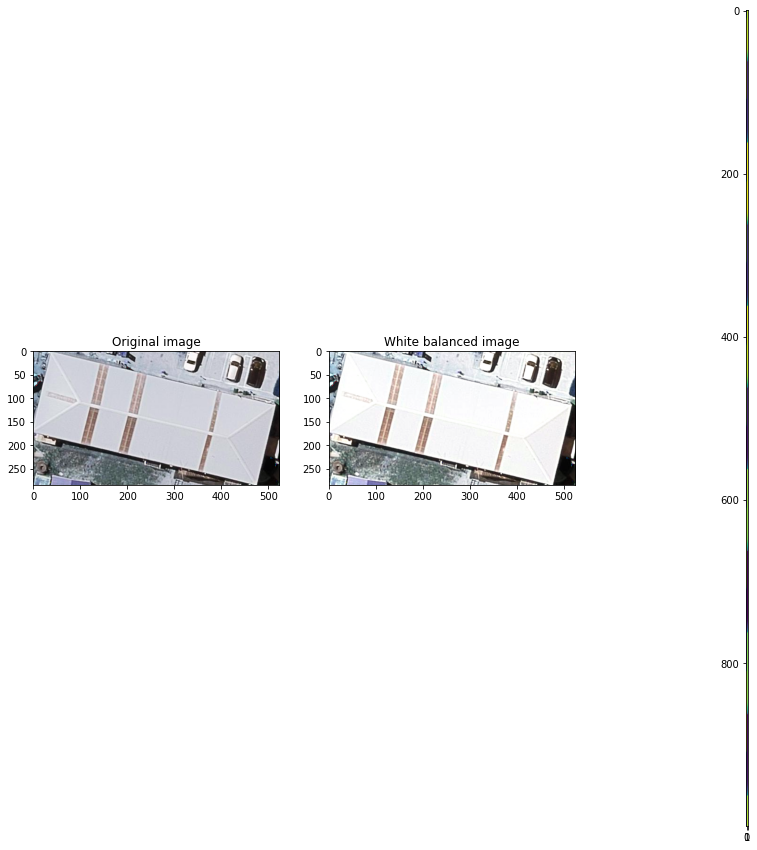

In [15]:
count = 1
for i in range(len(images_list)):
  image_np = cv2.imread(images_list[i], cv2.IMREAD_COLOR)
  image_white_patch = white_patch(image_np, 85)
  image_active_contour = active_contour_white_patch(images_list[i])

  fig = plt.figure(figsize = (15,15))

  fig.add_subplot(3, 3, count)
  plt.subplot(1,3,1)
  plt.imshow(image_np)
  plt.title('Original image')

  fig.add_subplot(3, 3, count+1)
  plt.subplot(1,3,2)
  plt.imshow(image_white_patch)
  plt.title('White balanced image')

  fig.add_subplot(3, 3, count+2)
  plt.subplot(1,3,3)
  plt.imshow(image_active_contour)
  print(image_active_contour.shape)
  # plt.title('Active contour image')

  count += 3
  plt.show()

### **Adaptive Canny Edge Detection**

In [16]:
def equalize(img):
    ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
    channels = cv2.split(ycrcb)
    cv2.equalizeHist(channels[0], channels[0])
    cv2.merge(channels, ycrcb)
    cv2.cvtColor(ycrcb, cv2.COLOR_YCR_CB2BGR, img)
    return img

In [17]:
def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)

    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)

    # return the edged image
    return edged

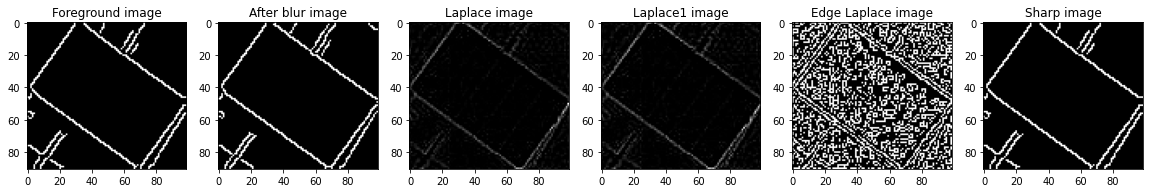

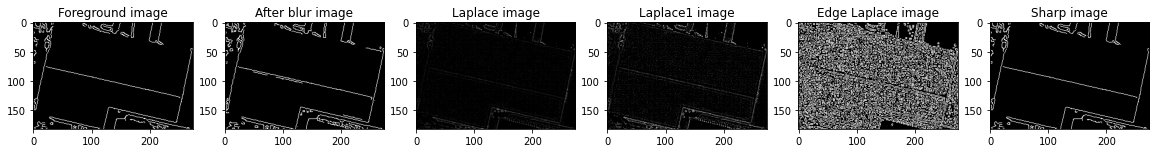

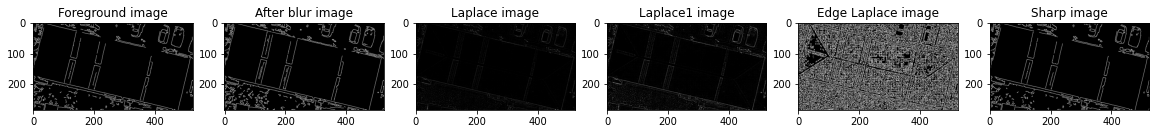

In [18]:
# loop over the images
count = 1
for i in range(len(images_list)):
    # load the image, convert it to grayscale, and blur it slightly
    image = cv2.imread(images_list[i])
    image_white_patch = white_patch(image, 85)
    gray = cv2.cvtColor(image_white_patch, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)

    fg = cv2.addWeighted(blurred, 1.5, gray, -0.5, 0)
    kernel_sharp = np.array((
        [-1, -1, -1],
        [-1, 9, -1],
        [-1, -1, -1]), dtype='int')
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    laplacian = laplacian.clip(min=0)

    auto = auto_canny(fg)
    auto1 = auto_canny(blurred)
    im = cv2.filter2D(auto, -1, kernel_sharp)
    # dst = cv2.addWeighted(gray, 0.5, auto, 0.5, 0)
    # dst1 = cv2.addWeighted(gray, 0.5, auto1, 0.5, 0)
    x = laplacian.astype(np.uint8)

    auto2 = auto_canny(x)
    im1 = cv2.filter2D(auto2, -1, kernel=kernel_sharp)

    fig = plt.figure(figsize=(20,20))
    
    fig.add_subplot(3, 6, count)
    plt.subplot(1,6,1)
    plt.imshow(auto, cmap = 'gray')
    plt.title('Foreground image')

    fig.add_subplot(3, 6, count+1)
    plt.subplot(1,6,2)
    plt.imshow(auto1, cmap = 'gray')
    plt.title('After blur image')

    fig.add_subplot(3, 6, count+2)
    plt.subplot(1,6,3)
    plt.imshow(laplacian, cmap = 'gray')
    plt.title('Laplace image')

    fig.add_subplot(3, 6, count+3)
    plt.subplot(1,6,4)
    plt.imshow(x, cmap = 'gray')
    plt.title('Laplace1 image')

    fig.add_subplot(3, 6, count+4)
    plt.subplot(1,6,5)
    plt.imshow(im1, cmap = 'gray')
    plt.title('Edge Laplace image')

    fig.add_subplot(3, 6, count+5)
    plt.subplot(1,6,6)
    plt.imshow(im, cmap = 'gray')
    plt.title('Sharp image')

    plt.show()
    count += 6

(285, 524) 124 (91, 99, 3)
[[461, 282, 7, 3], [221, 282, 11, 3], [520, 280, 4, 5], [408, 279, 19, 6], [140, 279, 5, 6], [32, 279, 1, 4], [12, 278, 3, 7], [404, 275, 38, 10], [238, 271, 4, 7], [29, 271, 6, 7], [127, 270, 9, 8], [366, 269, 17, 5], [80, 269, 53, 16], [0, 267, 2, 4], [6, 266, 8, 9], [346, 265, 20, 6], [273, 264, 5, 5], [71, 264, 3, 4], [31, 264, 7, 21], [38, 263, 47, 22], [28, 263, 2, 2], [318, 262, 2, 10], [277, 262, 5, 8], [8, 260, 27, 9], [131, 258, 6, 4], [53, 257, 11, 8], [257, 256, 7, 7], [0, 256, 4, 7], [0, 254, 28, 25], [105, 250, 5, 13], [252, 249, 44, 13], [32, 249, 6, 6], [280, 248, 82, 37], [0, 246, 7, 5], [15, 244, 8, 10], [122, 242, 2, 7], [267, 241, 12, 12], [15, 240, 14, 13], [181, 235, 5, 5], [514, 233, 10, 8], [235, 233, 35, 19], [233, 231, 2, 4], [52, 230, 9, 7], [8, 230, 6, 4], [135, 226, 10, 7], [503, 225, 4, 5], [117, 223, 15, 7], [518, 207, 5, 22], [65, 196, 169, 42], [2, 196, 33, 30], [513, 187, 11, 42], [350, 178, 30, 77], [0, 173, 459, 112], [116,

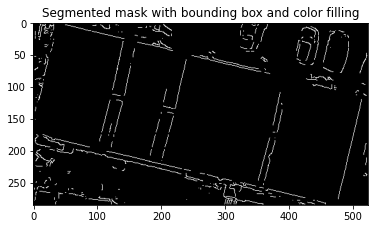

In [ ]:
# gray = cv2.cvtColor(auto, cv2.COLOR_BGR2GRAY)
contours = cv2.findContours(auto, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]

bb = []
print(auto.shape, len(contours), cv2.imread(images_list[0]).shape)
for cntr in contours:
    x,y,w,h = cv2.boundingRect(cntr)
    cv2.rectangle(auto, (x, y), (x+w, y+h), (0, 0, 255), 2)
    # cv2.rectangle(seg_with_bounded_box, (x, y), (x+w, y+h), (255, 255, 255), -1)
    bb.append([x,y,w,h])

print(bb)   

plt.imshow(auto, cmap = 'gray')
plt.title('Segmented mask with bounding box')
plt.show()
# plt.imshow(contours)

### **Polygon Approxiamation**

In [ ]:
im = cv2.imread(flat_image)
img = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)   # 1st image use
# img = cv2.bitwise_not(img)

In [ ]:
rows, cols = img.shape
white_img = cv2.bitwise_not(np.zeros(im.shape, np.uint8))
white_polygon = cv2.bitwise_not(np.zeros(im.shape, np.uint8))
white_gray = cv2.cvtColor(white_img, cv2.COLOR_BGR2GRAY)


In [ ]:
v = np.median(img)
sigma = 0.33
lower_thresh = int(max(0, (1.0 - sigma) * v))
upper_thresh = int(min(255, (1.0 + sigma) * v))
edges = cv2.Canny(img, lower_thresh, upper_thresh)

In [ ]:
lines = cv2.HoughLines(edges, 1, np.pi / 180, 30)
lines = np.reshape(lines, (lines.shape[0], lines.shape[2]))

In [ ]:
kmeans = KMeans(n_clusters=20).fit(lines)

In [ ]:
for line in kmeans.cluster_centers_:
    rho, theta = line
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * a)
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * a)
    cv2.line(white_gray, (x1, y1), (x2, y2), 0, 2)

In [ ]:
contours = cv2.findContours(white_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]

In [ ]:
for cnt in contours:
    cv2.drawContours(white_polygon, cnt, 0, 0, -1)
    man = []
    intense = []
    for col in range(cols):
        for row in range(rows):
            if cv2.pointPolygonTest(cnt, (col, row), False) == 1:
                man.append((row, col))
    for k in man:
        intense.append(im[k])
    intensity = mean(intense)
    # print (intensity)
    if intensity > 70:
        cv2.drawContours(white_polygon, [cnt], 0, 0, -1)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
white_gray1 = cv2.cvtColor(white_polygon, cv2.COLOR_BGR2GRAY)
opened = opening(white_gray1, selem=disk(4))

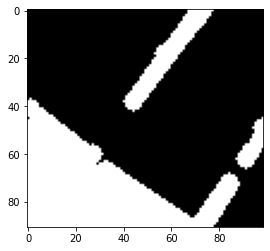

In [ ]:
opened = Image.fromarray(opened)
opened.save('opened.png')
plt.imshow(opened, cmap='gray')
plt.show()

POLY FILL

In [ ]:
def grayscale(im):
    return cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

In [ ]:
def white_image(im):
    return cv2.bitwise_not(np.zeros(im.shape, np.uint8))

In [ ]:
def hough_lines(im):
    original = im
    img = grayscale(im)
    blur = cv2.bilateralFilter(img, 5, sigmaColor=7, sigmaSpace=5)

    kernel_sharp = np.array((
        [-2, -2, -2],
        [-2, 17, -2],
        [-2, -2, -2]), dtype='int')
    sharp = cv2.filter2D(blur, -1, kernel_sharp)

    # White Blank Images for plotting Hough Lines and Polygon shapes
    white_img = white_image(im)
    white_gray = grayscale(white_img)
    # Canny Edge Detection
    v = np.median(sharp)
    sigma = 0.33
    lower_thresh = int(max(0, (1.0 - sigma) * v))
    upper_thresh = int(min(255, (1.0 + sigma) * v))
    edges = cv2.Canny(img, lower_thresh, upper_thresh)

    # Hough Lines
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 30)
    lines = np.reshape(lines, (lines.shape[0], lines.shape[2]))

    # K-Means Clustering
    kmeans = KMeans(n_clusters=5).fit(lines)

    # Plotting Hough Lines
    for line in kmeans.cluster_centers_:
        rho, theta = line
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * a)
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * a)
        cv2.line(white_gray, (x1, y1), (x2, y2), 0, 2)
    plt.imshow(white_gray)
    plt.show()
    contour_fill(original, white_gray)

In [ ]:
def contour_fill(im, white_gray):
    img = grayscale(im)
    rows, cols = img.shape

    # White Blank Image for polygon drawing
    white_polygon = white_image(im)

    # Contours in the white image with Hough Lines
    contours = cv2.findContours(white_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]

    for cnt in contours:
        # Drawing the contours on image with Hough Lines
        cv2.drawContours(white_polygon, cnt, 0, 0, -1)

        # Points inside the contour
        inside_point = []
        # Intensity of points inside the contour
        intensity = []

        for col in range(cols):
            for row in range(rows):
                # Point polygon test
                if cv2.pointPolygonTest(cnt, (col, row), False) == 1:
                    inside_point.append((row, col))

        # Intensity of points inside the polygon
        for inside in inside_point:
            intensity.append(im[inside])
        mean_intensity = mean(intensity)

        # Mean Intensity Value threshold
        if mean_intensity > 150:
            cv2.drawContours(white_polygon, [cnt], 0, 0, -1)
            # Filling the polygon
    poly_gaps = cv2.cvtColor(white_polygon, cv2.COLOR_BGR2GRAY)
    opened = opening(poly_gaps, selem=disk(4))
    plt.imshow(opened, cmap='gray')
    plt.show()
    return opened

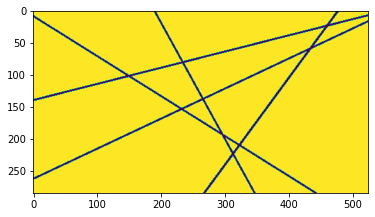

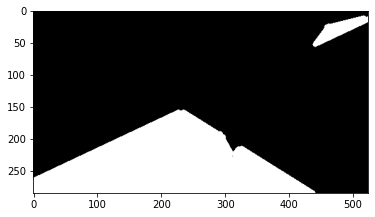

In [ ]:
hough_lines(cv2.imread(hip_image))
# image = cv2.imread('ob.png')
# hough_lines(image)

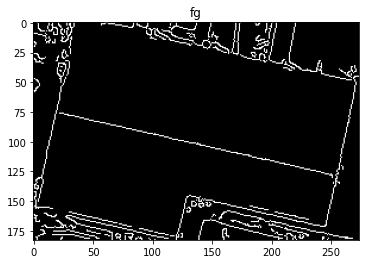

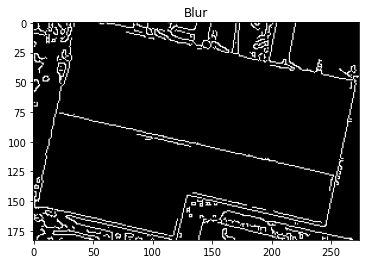

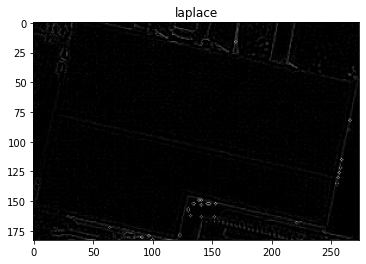

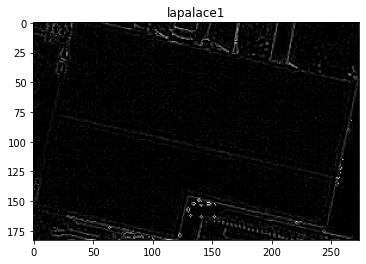

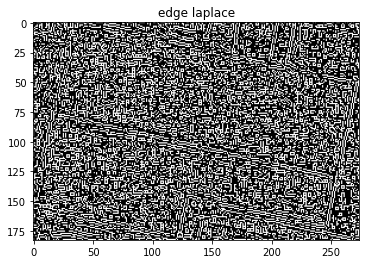

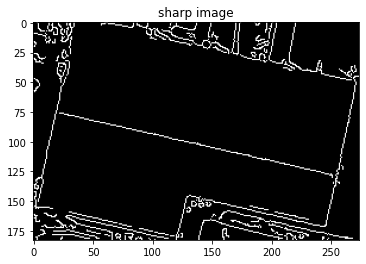

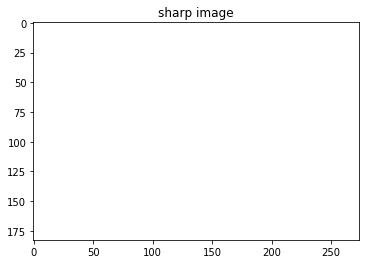

array([[  0, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [ ]:
image = cv2.imread(gable_image)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (3, 3), 0)

fg = cv2.addWeighted(blurred, 1.5, gray, -0.5, 0)
kernel_sharp = np.array((
    [-1, -1, -1],
    [-1, 9, -1],
    [-1, -1, -1]), dtype='int')
laplacian = cv2.Laplacian(gray, cv2.CV_64F)
laplacian = laplacian.clip(min=0)

auto = auto_canny(fg)
auto1 = auto_canny(blurred)
im = cv2.filter2D(auto, -1, kernel_sharp)
# dst = cv2.addWeighted(gray, 0.5, auto, 0.5, 0)
# dst1 = cv2.addWeighted(gray, 0.5, auto1, 0.5, 0)
x = laplacian.astype(np.uint8)

auto2 = auto_canny(x)
im1 = cv2.filter2D(auto2, -1, kernel=kernel_sharp)
plt.figure()
plt.title("fg")
plt.imshow(auto, cmap='gray')
plt.figure()
plt.title("Blur")
plt.imshow(auto1, cmap='gray')
plt.figure()
plt.title("laplace")
plt.imshow(laplacian, cmap='gray')
plt.figure()
plt.title("lapalace1")
plt.imshow(x, cmap='gray')
plt.figure()
plt.title("edge laplace")
plt.imshow(im1, cmap='gray')
plt.figure()
plt.title("sharp image")
plt.imshow(im, cmap='gray')


auto_2 = white_image(auto1)

plt.figure()
plt.title("sharp image")
plt.imshow(auto_2, cmap='gray')

contour_fill(image, auto_2)

POLYGON FIT

In [ ]:
class ShapeDetector:
    def __init__(self):
        pass

    def detect(self, c):
        # initialize the shape name and approximate the contour
        shape = "unidentified"
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.04 * peri, True)

        # if the shape is a triangle, it will have 3 vertices
        if len(approx) == 3:
            shape = "triangle"

        # if the shape has 4 vertices, it is either a square or
        # a rectangle
        elif len(approx) == 4:
            # compute the bounding box of the contour and use the
            # bounding box to compute the aspect ratio
            (x, y, w, h) = cv2.boundingRect(approx)
            ar = w / float(h)

            # a square will have an aspect ratio that is approximately
            # equal to one, otherwise, the shape is a rectangle
            shape = "square" if ar >= 0.95 and ar <= 1.05 else "rectangle"

        # if the shape is a pentagon, it will have 5 vertices
        elif len(approx) == 5:
            shape = "pentagon"

        # otherwise, we assume the shape is a circle
        else:
            shape = "circle"

        # return the name of the shape
        return shape